In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:

def load_images_from_folders(sar_dir, optical_dir):
    sar_images = []
    optical_images = []

    sar_files = sorted(os.listdir(sar_dir))
    optical_files = sorted(os.listdir(optical_dir))

    # Debugging: Print the list of files
    print(f"SAR files: {sar_files}")
    print(f"Optical files: {optical_files}")

    # Create a dictionary to map filenames without the varying parts
    sar_dict = {f[-7:-4]: f for f in sar_files}  # Extract the last 3 characters before ".png"
    optical_dict = {f[-7:-4]: f for f in optical_files}

    for key in sar_dict:
        if key in optical_dict:
            sar_file = sar_dict[key]
            optical_file = optical_dict[key]

            # Debugging: Print the matched filenames
            print(f"Matching {sar_file} with {optical_file}")

            sar_img = cv2.imread(os.path.join(sar_dir, sar_file), cv2.IMREAD_GRAYSCALE)
            optical_img = cv2.imread(os.path.join(optical_dir, optical_file))

            if sar_img is not None and optical_img is not None:
                # Normalize images to [0, 1]
                sar_img = sar_img.astype(np.float32) / 255.0
                optical_img = optical_img.astype(np.float32) / 255.0

                # Add channel dimension for grayscale SAR image
                sar_img = np.expand_dims(sar_img, axis=-1)

                sar_images.append(sar_img)
                optical_images.append(optical_img)
            else:
                print(f"Warning: Could not load {sar_file} or {optical_file}")
        else:
            print(f"Warning: Could not find match for: {key}")

    return np.array(sar_images), np.array(optical_images)

# sar_dir = 'archive/v_2/urban/s1'
# optical_dir = 'archive/v_2/urban/s2'

# sar_images, optical_images = load_images_from_folders(sar_dir, optical_dir)

# print(f"Loaded {len(sar_images)} SAR images and {len(optical_images)} optical images.")


In [3]:
sar_dirs = ['SAR patch1']        # List of SAR directories
optical_dirs = ['patch1'] # List of corresponding optical directories

sar_images = []
optical_images = []

for sar_dir, optical_dir in zip(sar_dirs, optical_dirs):
    sar_imgs, optical_imgs = load_images_from_folders(sar_dir, optical_dir)
    sar_images.extend(sar_imgs)
    optical_images.extend(optical_imgs)

print(f"Loaded {len(sar_images)} SAR images and {len(optical_images)} optical images.")



SAR files: ['patch_0_x30_y14.tif', 'patch_1000_x25_y32.tif', 'patch_1001_x26_y32.tif', 'patch_1002_x27_y32.tif', 'patch_1003_x28_y32.tif', 'patch_1004_x29_y32.tif', 'patch_1005_x30_y32.tif', 'patch_1006_x31_y32.tif', 'patch_1007_x32_y32.tif', 'patch_1008_x33_y32.tif', 'patch_1009_x34_y32.tif', 'patch_100_x21_y16.tif', 'patch_1010_x35_y32.tif', 'patch_1011_x36_y32.tif', 'patch_1012_x37_y32.tif', 'patch_1013_x38_y32.tif', 'patch_1014_x39_y32.tif', 'patch_1015_x40_y32.tif', 'patch_1016_x41_y32.tif', 'patch_1017_x42_y32.tif', 'patch_1018_x43_y32.tif', 'patch_1019_x44_y32.tif', 'patch_101_x22_y16.tif', 'patch_1020_x45_y32.tif', 'patch_1021_x46_y32.tif', 'patch_1022_x47_y32.tif', 'patch_1023_x48_y32.tif', 'patch_1024_x49_y32.tif', 'patch_1025_x50_y32.tif', 'patch_1026_x51_y32.tif', 'patch_1027_x52_y32.tif', 'patch_1028_x53_y32.tif', 'patch_1029_x54_y32.tif', 'patch_102_x23_y16.tif', 'patch_1030_x55_y32.tif', 'patch_1031_x0_y33.tif', 'patch_1032_x1_y33.tif', 'patch_1033_x2_y33.tif', 'patch_10

In [4]:
def unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Create the U-Net model
input_shape = (256, 256, 1)  # Adjust this if you use different image sizes
model = unet_model(input_shape)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [5]:
print(f"Number of SAR images: {len(sar_images)}")
print(f"Number of Optical images: {len(optical_images)}")


Number of SAR images: 179
Number of Optical images: 179


In [6]:
# Train the model
# Example: Reshape if your images are missing the width dimension


# Assuming sar_images is a list of images
# First, convert the list to a NumPy array
sar_images = np.array(sar_images)

# Now you can check the shape and reshape if necessary
print(f"Original shape of SAR images: {sar_images.shape}")

# Check if the images have the correct shape (num_images, 256, 256, 1)
if sar_images.ndim == 3:  # This means the shape is (num_images, 256, 256)
    # Reshape to (num_images, 256, 256, 1) by adding the channel dimension
    sar_images = sar_images.reshape(-1, 256, 256, 1)
    print(f"Reshaped SAR images to: {sar_images.shape}")
elif sar_images.ndim == 4:
    print(f"SAR images already have the correct shape: {sar_images.shape}")
else:
    print("Unexpected shape for SAR images")
    

optical_images = np.array(optical_images)

# Now you can check the shape and reshape if necessary
print(f"Original shape of SAR images: {optical_images.shape}")

# Check if the images have the correct shape (num_images, 256, 256, 1)
if sar_images.ndim == 3:  # This means the shape is (num_images, 256, 256)
    # Reshape to (num_images, 256, 256, 1) by adding the channel dimension
    optical_images = optical_images.reshape(-1, 256, 256, 1)
    print(f"Reshaped SAR images to: {sar_images.shape}")
elif optical_images.ndim == 4:
    print(f"SAR images already have the correct shape: {sar_images.shape}")
else:
    print("Unexpected shape for SAR images")






Original shape of SAR images: (179, 512, 512, 1)
SAR images already have the correct shape: (179, 512, 512, 1)
Original shape of SAR images: (179, 512, 512, 3)
SAR images already have the correct shape: (179, 512, 512, 1)


In [7]:


# Shuffle the data
sar_images, optical_images = shuffle(sar_images, optical_images)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['accuracy'])

# Train the model over multiple epochs and with increased epochs per chunk
epochs = 10
batch_size = 2

for epoch in range(epochs):
    for i in range(0, len(sar_images), 100):
        history = model.fit(sar_images[i:i+100], optical_images[i:i+100], epochs=1, batch_size=batch_size, validation_split=0.1)


ValueError: in user code:

    File "c:\Users\sarve\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\sarve\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\sarve\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\sarve\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\sarve\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\sarve\anaconda3\envs\py310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 256, 256, 1), found shape=(2, 512, 512, 1)


In [ ]:
# for i in range(0,len(sar_images),100):
#     history = model.fit(sar_images[i:i+100], optical_images[i:i+100], epochs=5, batch_size=2, validation_split=0.1)


1/1 [==============================] - 3s 3s/step - loss: 0.0385 - accuracy: 0.3897
Loss: 0.03853535279631615, Accuracy: 0.38972169160842896
1/1 [==============================] - 0s 135ms/step


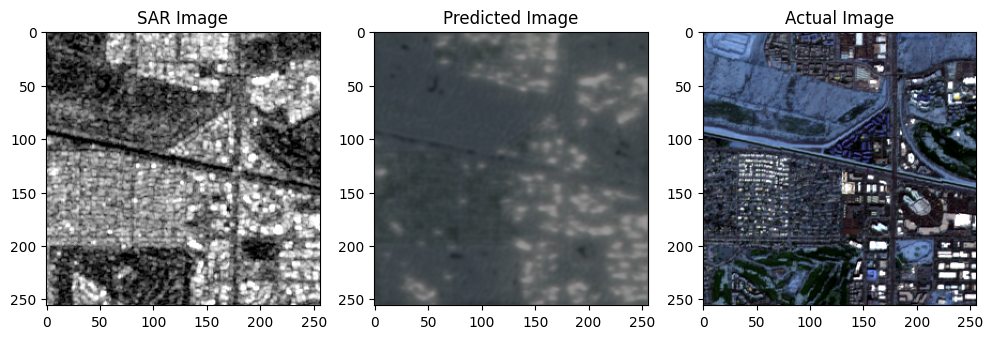

1/1 [==============================] - 0s 25ms/step


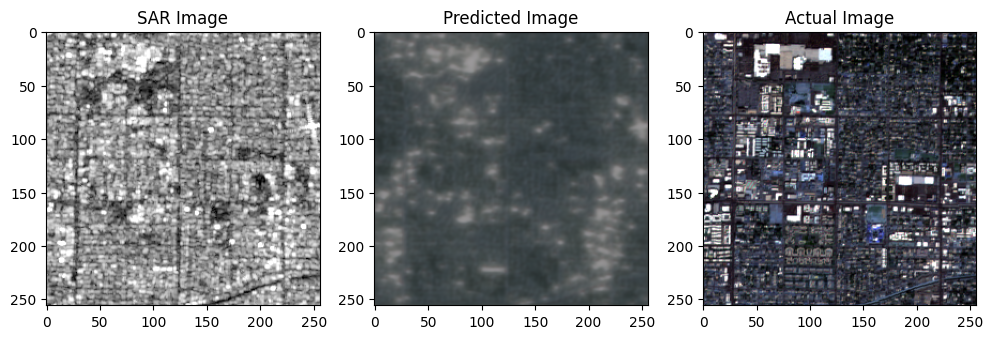

1/1 [==============================] - 0s 20ms/step


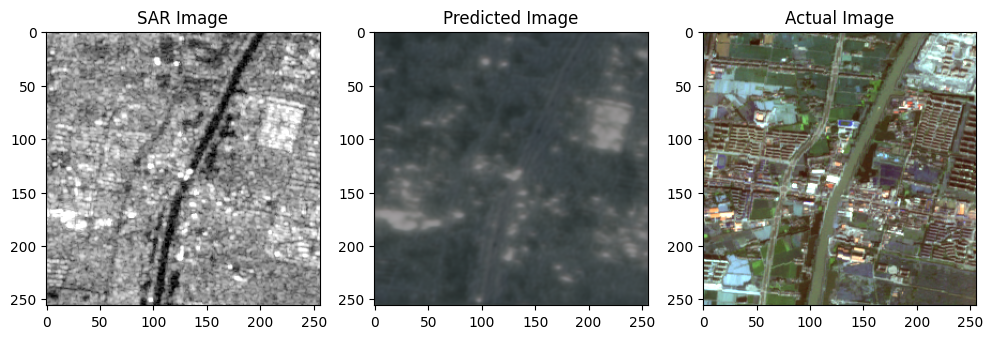

1/1 [==============================] - 0s 26ms/step


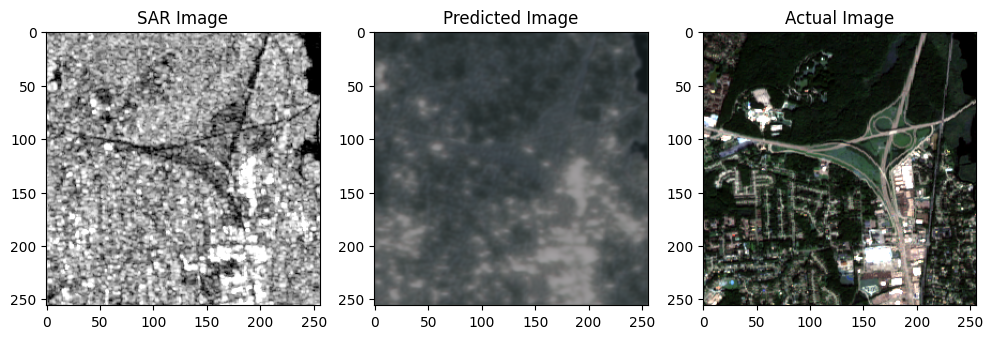

1/1 [==============================] - 0s 16ms/step


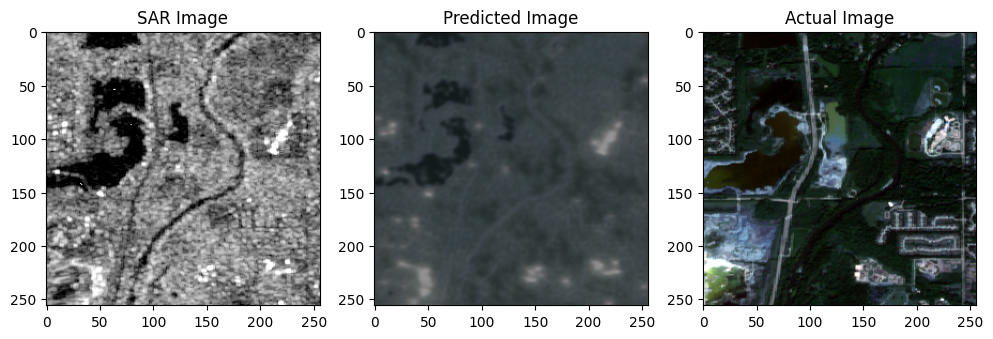

1/1 [==============================] - 0s 16ms/step


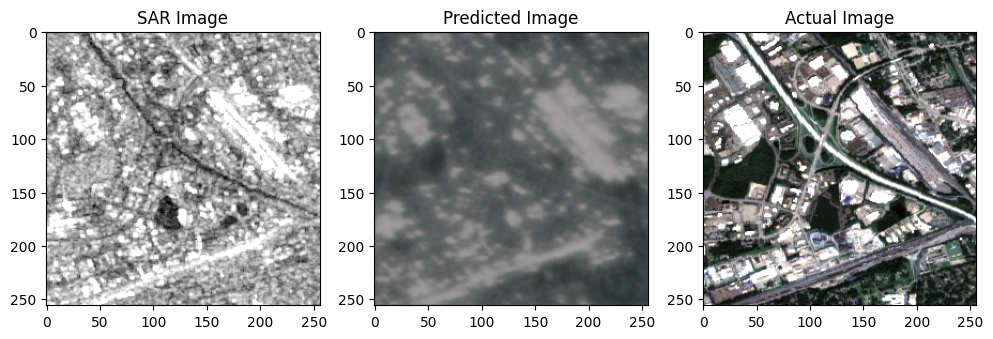

1/1 [==============================] - 0s 21ms/step


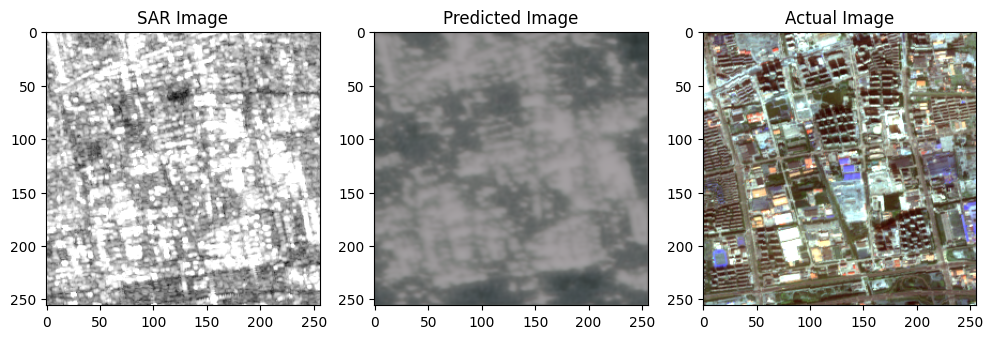

1/1 [==============================] - 0s 22ms/step


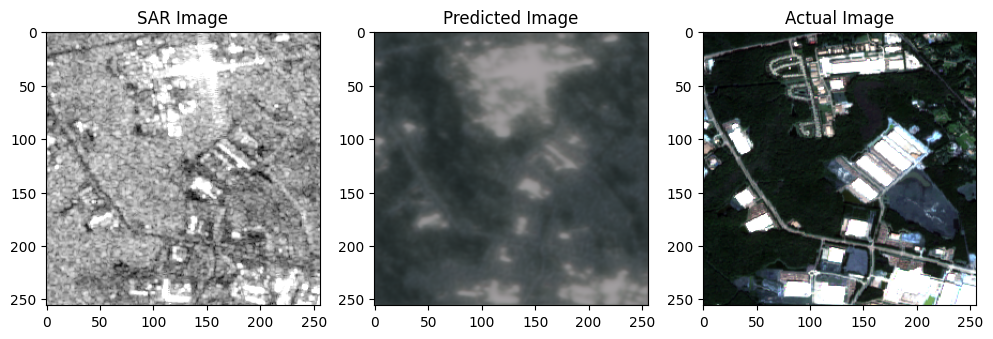

1/1 [==============================] - 0s 25ms/step


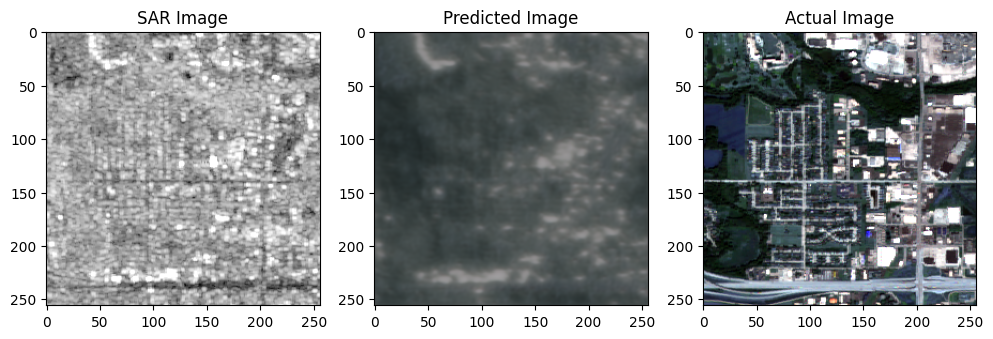

1/1 [==============================] - 0s 20ms/step


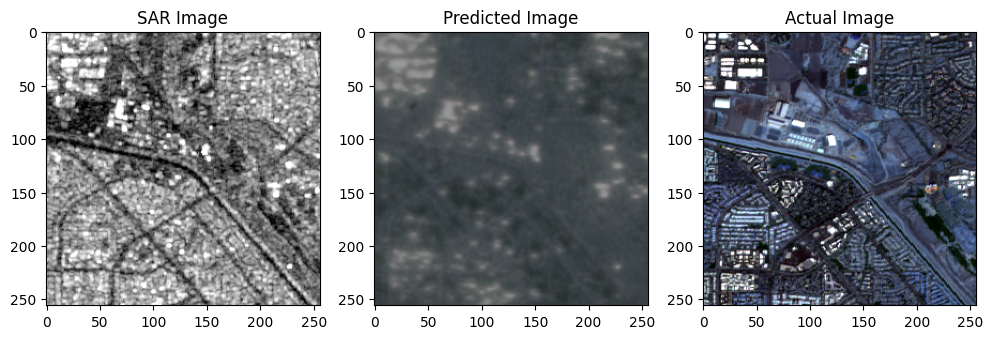

In [ ]:
# Evaluate the model
loss, acc = model.evaluate(sar_images[0:5], optical_images[0:5])
print(f"Loss: {loss}, Accuracy: {acc}")

# Predict and visualize results
def plot_results(sar_img, predicted_img, actual_img):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("SAR Image")
    plt.imshow(sar_img.squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Image")
    plt.imshow(predicted_img)

    plt.subplot(1, 3, 3)
    plt.title("Actual Image")
    plt.imshow(actual_img)

    plt.show()

# Test on a single image
for i in range(0,10):
      # Change this to test different images
    sar_img = sar_images[i:i+1]
    predicted_img = model.predict(sar_img)
    actual_img = optical_images[i]

    plot_results(sar_img[0], predicted_img[0], actual_img)
